In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
style.use('ggplot')

In [2]:
variables = ['SiO3','NO3', 'PO4'] 

In [3]:
keepthese = ['z_t','z_t_150m','time_bound','TAREA','REGION_MASK', 'time'] + variables
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = keepthese +list(coords.values())+['dz','KMT']

In [9]:
case1 = 'g.e21.G1850ECOIAF.T62_g16.004' # CESM2.1, "run2"
case2 = 'g.e21.G1850ECOIAF.T62_g16.005' # CESM2.1, like above but with increased alphaPI for diatoms
case3 = 'g.e21.G1850ECOIAF.T62_g17.002_3pft' # CESM2.2, with increased alphaPI for diatoms
case4 = 'g.e21.G1850ECOIAF.T62_g17.001' # CESM2.2, cocco version
case5 = 'g.e21.G1850ECOIAF.T62_g17.002' # CESM2.2, cocco version, retune

In [10]:
path1 = '/glade/scratch/kristenk/archive/' + case1 + '/ocn/proc/tseries/month_1'
path2 = '/glade/scratch/kristenk/archive/' + case2 + '/ocn/proc/tseries/month_1'
path3 = '/glade/scratch/kristenk/archive/' + case3 + '/ocn/proc/tseries/month_1'
path4 = '/glade/scratch/kristenk/archive/' + case4 + '/ocn/proc/tseries/month_1'
path5 = '/glade/scratch/kristenk/archive/' + case5 + '/ocn/proc/tseries/month_1'

Get Reference case "Run 2"

In [11]:
%%time

ds_list = []
print(f'reading {case1}')
ds_ref = xr.Dataset()
for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path1}/{case1}.pop.h.{v}.000101-006212.nc'))     #just getting the fist IAF
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    ds_ref = xr.merge((ds_ref, dsv))
    ds_list.append(ds_ref)

reading g.e21.G1850ECOIAF.T62_g16.004
SiO3
NO3
PO4
CPU times: user 1.11 s, sys: 65.7 ms, total: 1.18 s
Wall time: 2.05 s


Get cesm2.1 alphaPI case

In [12]:
%%time

ds_list = []
print(f'reading {case1}')
ds2 = xr.Dataset()
for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path2}/{case2}.pop.h.{v}.000101-002012.nc'))     #just getting the fist IAF
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    ds2 = xr.merge((ds2, dsv))
    ds_list.append(ds2)

reading g.e21.G1850ECOIAF.T62_g16.004
SiO3
NO3
PO4
CPU times: user 1.09 s, sys: 53.5 ms, total: 1.14 s
Wall time: 1.74 s


Get cesm2.2 alphaPI case

In [16]:
%%time

ds_list = []
print(f'reading {case3}')
ds3 = xr.Dataset()
for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path3}/{case3}.pop.h.{v}.000101-002012.nc'))     #just getting the fist IAF
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    ds3 = xr.merge((ds3, dsv))
    ds_list.append(ds3)

reading g.e21.G1850ECOIAF.T62_g17.002_3pft
SiO3
NO3
PO4
CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.91 s


Get CESM2.2 cocco case

In [17]:
%%time

ds_list = []
print(f'reading {case1}')
ds4 = xr.Dataset()
for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path4}/{case4}.pop.h.{v}.000101-002012.nc'))     #just getting the fist IAF
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    ds4 = xr.merge((ds4, dsv))
    ds_list.append(ds4)

reading g.e21.G1850ECOIAF.T62_g16.004
SiO3
NO3
PO4
CPU times: user 1.15 s, sys: 13.7 ms, total: 1.17 s
Wall time: 1.78 s


Get CESM2.2 with coccos, re-tuned slightly

In [18]:
%%time

ds_list = []
print(f'reading {case1}')
ds5 = xr.Dataset()
for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path5}/{case5}.pop.h.{v}.000101-002012.nc'))     #just getting the fist IAF
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    ds5 = xr.merge((ds5, dsv))
    ds_list.append(ds5)

reading g.e21.G1850ECOIAF.T62_g16.004
SiO3
NO3
PO4
CPU times: user 1.16 s, sys: 42 ms, total: 1.2 s
Wall time: 1.85 s


Got all the data read in; now do some adjustments

In [19]:
tlen=len(ds_ref.time)
#resetting the time variable so that it's a mean of the time bounds
ds_ref["time"] = ds_ref.time_bound.compute().mean(dim="d2")
ds2["time"] = ds2.time_bound.compute().mean(dim="d2")
ds3["time"] = ds3.time_bound.compute().mean(dim="d2")
ds4["time"] = ds4.time_bound.compute().mean(dim="d2")
ds5["time"] = ds5.time_bound.compute().mean(dim="d2")

In [20]:
ds_ref = ds_ref.drop([v for v in ds_ref.variables if v not in keep_vars])
ds2 = ds2.drop([v for v in ds2.variables if v not in keep_vars])
ds3 = ds3.drop([v for v in ds3.variables if v not in keep_vars])
ds4 = ds4.drop([v for v in ds4.variables if v not in keep_vars])
ds5 = ds5.drop([v for v in ds5.variables if v not in keep_vars])

In [21]:
#just keep the first 20 years for comparison to test runs
ds_ref = ds_ref.isel(time=slice(0,240))

Make annual means

In [22]:
%%time
ds_ref_annmean_ts = ds_ref.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 2min 50s, sys: 59 s, total: 3min 49s
Wall time: 2min 4s


In [23]:
%%time
ds2_annmean_ts = ds2.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 2min 44s, sys: 1min 1s, total: 3min 45s
Wall time: 2min 5s


In [24]:
%%time
ds3_annmean_ts = ds3.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 2min 50s, sys: 1min 2s, total: 3min 52s
Wall time: 2min 8s


In [25]:
%%time
ds4_annmean_ts = ds4.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 2min 43s, sys: 1min 3s, total: 3min 47s
Wall time: 2min 6s


In [26]:
%%time
ds5_annmean_ts = ds5.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 2min 39s, sys: 1min 5s, total: 3min 44s
Wall time: 2min 5s


Get WOA

In [27]:
#just getting this for the coords (that don't have nans)
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc'
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds_ref.z_t
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01
years = np.arange(len(ds_ref_annmean_ts.time))

Calculate RMSE

In [28]:
ds_ref_mean = ds_ref_annmean_ts.isel(time=slice(14,20)).mean(dim='time')
ds2_mean = ds2_annmean_ts.isel(time=slice(14,20)).mean(dim='time')
ds3_mean = ds3_annmean_ts.isel(time=slice(14,20)).mean(dim='time')
ds4_mean = ds4_annmean_ts.isel(time=slice(14,20)).mean(dim='time')
ds5_mean = ds5_annmean_ts.isel(time=slice(14,20)).mean(dim='time')

In [29]:
ref_rmse_no3_surf=esmlab.statistics.weighted_rmsd(ds_ref_mean.NO3.isel(z_t=0), ds_woa.NO3.isel(z_t=0), dim=['nlat', 'nlon'], weights=area)
ref_rmse_no3_surf.values

array(2.17717226)

In [30]:
ds2_rmse_no3_surf=esmlab.statistics.weighted_rmsd(ds2_mean.NO3.isel(z_t=0), ds_woa.NO3.isel(z_t=0), dim=['nlat', 'nlon'], weights=area)
ds2_rmse_no3_surf.values

array(2.08985902)

In [31]:
ds3_rmse_no3_surf=esmlab.statistics.weighted_rmsd(ds3_mean.NO3.isel(z_t=0), ds_woa.NO3.isel(z_t=0), dim=['nlat', 'nlon'], weights=area)
ds3_rmse_no3_surf.values

array(2.09084312)

In [32]:
ds4_rmse_no3_surf=esmlab.statistics.weighted_rmsd(ds4_mean.NO3.isel(z_t=0), ds_woa.NO3.isel(z_t=0), dim=['nlat', 'nlon'], weights=area)
ds4_rmse_no3_surf.values

array(6.36790524)

In [33]:
ds5_rmse_no3_surf=esmlab.statistics.weighted_rmsd(ds5_mean.NO3.isel(z_t=0), ds_woa.NO3.isel(z_t=0), dim=['nlat', 'nlon'], weights=area)
ds5_rmse_no3_surf.values

array(6.28202991)

In [34]:
ref_rmse_sio3_surf=esmlab.statistics.weighted_rmsd(ds_ref_mean.SiO3.isel(z_t=0), ds_woa.SiO3.isel(z_t=0), dim=['nlat', 'nlon'], weights=area)
ref_rmse_sio3_surf.values

array(6.39582222)

In [35]:
ds2_rmse_sio3_surf=esmlab.statistics.weighted_rmsd(ds2_mean.SiO3.isel(z_t=0), ds_woa.SiO3.isel(z_t=0), dim=['nlat', 'nlon'], weights=area)
ds2_rmse_sio3_surf.values

array(7.01091534)

In [36]:
ds3_rmse_sio3_surf=esmlab.statistics.weighted_rmsd(ds3_mean.SiO3.isel(z_t=0), ds_woa.SiO3.isel(z_t=0), dim=['nlat', 'nlon'], weights=area)
ds3_rmse_sio3_surf.values

array(7.03745423)

In [37]:
ds4_rmse_sio3_surf=esmlab.statistics.weighted_rmsd(ds4_mean.SiO3.isel(z_t=0), ds_woa.SiO3.isel(z_t=0), dim=['nlat', 'nlon'], weights=area)
ds4_rmse_sio3_surf.values

array(8.99860214)

In [38]:
ds5_rmse_sio3_surf=esmlab.statistics.weighted_rmsd(ds5_mean.SiO3.isel(z_t=0), ds_woa.SiO3.isel(z_t=0), dim=['nlat', 'nlon'], weights=area)
ds5_rmse_sio3_surf.values

array(8.99135666)

Southern Ocean means

In [39]:
woa_SO = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
woa_SO['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
woa_SO['NO3'] = esmlab.weighted_mean(ds_woa['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
woa_SO['PO4'] = esmlab.weighted_mean(ds_woa['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [40]:
#do reference dataset (004)
ts_SO_ref = xr.Dataset({v: ds_ref_annmean_ts[v] for v in ['time','z_t']})
ts_SO_ref['SiO3'] = esmlab.weighted_mean(ds_ref_annmean_ts['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_ref['NO3'] = esmlab.weighted_mean(ds_ref_annmean_ts['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_ref['PO4'] = esmlab.weighted_mean(ds_ref_annmean_ts['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [41]:
#get cesm2.1 alphaPI 
ts_SO_2 = xr.Dataset({v: ds_ref_annmean_ts[v] for v in ['time','z_t']})
ts_SO_2['SiO3'] = esmlab.weighted_mean(ds2_annmean_ts['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_2['NO3'] = esmlab.weighted_mean(ds2_annmean_ts['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_2['PO4'] = esmlab.weighted_mean(ds2_annmean_ts['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [42]:
#get cesm2.2 alphaPI 
ts_SO_3 = xr.Dataset({v: ds_ref_annmean_ts[v] for v in ['time','z_t']})
ts_SO_3['SiO3'] = esmlab.weighted_mean(ds3_annmean_ts['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_3['NO3'] = esmlab.weighted_mean(ds3_annmean_ts['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_3['PO4'] = esmlab.weighted_mean(ds3_annmean_ts['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [43]:
#get cesm2.2 cocco
ts_SO_4 = xr.Dataset({v: ds_ref_annmean_ts[v] for v in ['time','z_t']})
ts_SO_4['SiO3'] = esmlab.weighted_mean(ds4_annmean_ts['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_4['NO3'] = esmlab.weighted_mean(ds4_annmean_ts['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_4['PO4'] = esmlab.weighted_mean(ds4_annmean_ts['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [44]:
#get cesm2.2 cocco
ts_SO_5 = xr.Dataset({v: ds_ref_annmean_ts[v] for v in ['time','z_t']})
ts_SO_5['SiO3'] = esmlab.weighted_mean(ds5_annmean_ts['SiO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_5['NO3'] = esmlab.weighted_mean(ds5_annmean_ts['NO3'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()
ts_SO_5['PO4'] = esmlab.weighted_mean(ds5_annmean_ts['PO4'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

In [45]:
diff_SO_ref = ts_SO_ref - woa_SO
diff_SO_ref=diff_SO_ref.transpose()
diff_SO_ref_top=diff_SO_ref.isel(z_t=slice(0,40))
diff_SO_ref_bottom=diff_SO_ref.isel(z_t=slice(40,60))

In [46]:
diff_SO_2 = ts_SO_2 - woa_SO
diff_SO_2=diff_SO_2.transpose()
diff_SO_2_top=diff_SO_2.isel(z_t=slice(0,40))
diff_SO_2_bottom=diff_SO_2.isel(z_t=slice(40,60))

In [47]:
diff_SO_3 = ts_SO_3 - woa_SO
diff_SO_3=diff_SO_3.transpose()
diff_SO_3_top=diff_SO_3.isel(z_t=slice(0,40))
diff_SO_3_bottom=diff_SO_3.isel(z_t=slice(40,60))

In [48]:
diff_SO_4 = ts_SO_4 - woa_SO
diff_SO_4=diff_SO_4.transpose()
diff_SO_4_top=diff_SO_4.isel(z_t=slice(0,40))
diff_SO_4_bottom=diff_SO_4.isel(z_t=slice(40,60))

In [49]:
diff_SO_5 = ts_SO_5 - woa_SO
diff_SO_5 = diff_SO_5.transpose()
diff_SO_5_top = diff_SO_5.isel(z_t=slice(0,40))
diff_SO_5_bottom = diff_SO_5.isel(z_t=slice(40,60))

In [50]:
z_top=depths.isel(z_t=slice(0,40))
z_bottom=depths.isel(z_t=slice(40,60))

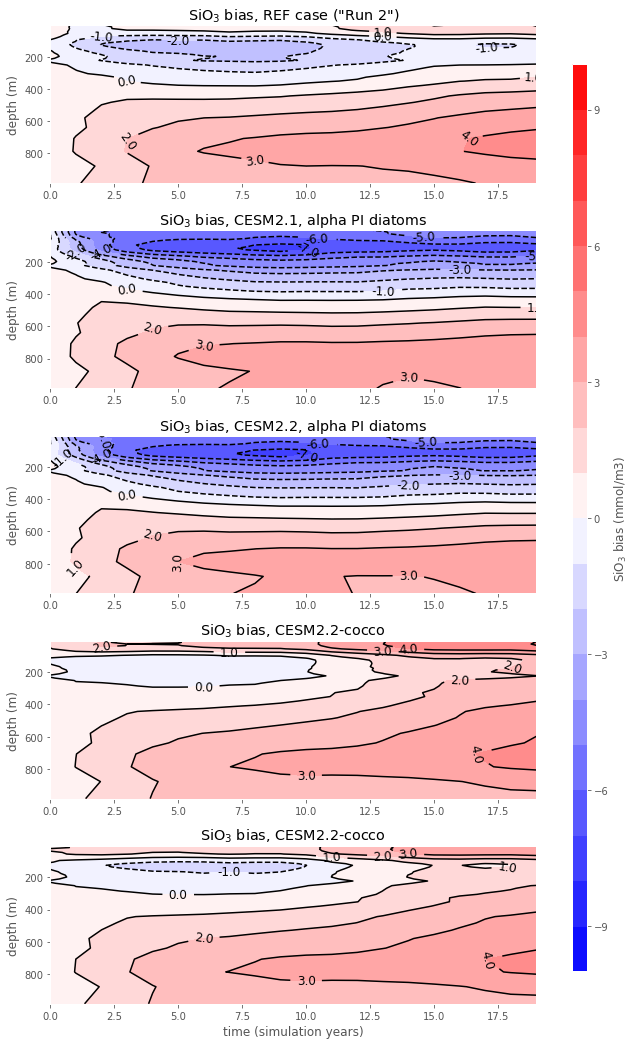

In [51]:
fig = plt.figure(figsize=(10,18))

#plt.title('Southern SiO$_3$ REF case: Run 2', fontsize=14)
levels = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]

ax = fig.add_subplot(5,1,1)
pc=ax.contourf(years, z_top, diff_SO_ref_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_ref_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('SiO$_3$ bias, REF case ("Run 2")')

fig.subplots_adjust(right=0.8,hspace=0.3)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

#----------------------------------
ax = fig.add_subplot(5,1,2)
pc=ax.contourf(years, z_top, diff_SO_2_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_2_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('SiO$_3$ bias, CESM2.1, alpha PI diatoms')



#----------------------------------
ax = fig.add_subplot(5,1,3)
pc=ax.contourf(years, z_top, diff_SO_3_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_3_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('SiO$_3$ bias, CESM2.2, alpha PI diatoms')


#----------------------------------
ax = fig.add_subplot(5,1,4)
pc=ax.contourf(years, z_top, diff_SO_4_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_4_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('SiO$_3$ bias, CESM2.2-cocco')

#----------------------------------
ax = fig.add_subplot(5,1,5)
pc=ax.contourf(years, z_top, diff_SO_5_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_SO_5_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('SiO$_3$ bias, CESM2.2-cocco');

Global means

In [52]:
woa_glb = xr.Dataset({v: ds_woa[v] for v in ['z_t']})
woa_glb['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()
woa_glb['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
woa_glb['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=area, dim=['nlat', 'nlon']).compute()

In [53]:
#do reference dataset (004)
ts_glb_ref = xr.Dataset({v: ds_ref_annmean_ts[v] for v in ['time','z_t']})
ts_glb_ref['SiO3'] = esmlab.weighted_mean(ds_ref_annmean_ts['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_glb_ref['NO3'] = esmlab.weighted_mean(ds_ref_annmean_ts['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_glb_ref['PO4'] = esmlab.weighted_mean(ds_ref_annmean_ts['PO4'], weights=area, dim=['nlat', 'nlon']).compute()

In [54]:
#do cesm2.1 alpha pi
ts_glb_2= xr.Dataset({v: ds_ref_annmean_ts[v] for v in ['time','z_t']})
ts_glb_2['SiO3'] = esmlab.weighted_mean(ds2_annmean_ts['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_glb_2['NO3'] = esmlab.weighted_mean(ds2_annmean_ts['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_glb_2['PO4'] = esmlab.weighted_mean(ds2_annmean_ts['PO4'], weights=area, dim=['nlat', 'nlon']).compute()

In [55]:
#do cesm2.2 alpha pi
ts_glb_3= xr.Dataset({v: ds_ref_annmean_ts[v] for v in ['time','z_t']})
ts_glb_3['SiO3'] = esmlab.weighted_mean(ds3_annmean_ts['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_glb_3['NO3'] = esmlab.weighted_mean(ds3_annmean_ts['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_glb_3['PO4'] = esmlab.weighted_mean(ds3_annmean_ts['PO4'], weights=area, dim=['nlat', 'nlon']).compute()

In [56]:
#do cesm2.2 cocco
ts_glb_4= xr.Dataset({v: ds_ref_annmean_ts[v] for v in ['time','z_t']})
ts_glb_4['SiO3'] = esmlab.weighted_mean(ds4_annmean_ts['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_glb_4['NO3'] = esmlab.weighted_mean(ds4_annmean_ts['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_glb_4['PO4'] = esmlab.weighted_mean(ds4_annmean_ts['PO4'], weights=area, dim=['nlat', 'nlon']).compute()

In [57]:
#do cesm2.2 cocco
ts_glb_5= xr.Dataset({v: ds_ref_annmean_ts[v] for v in ['time','z_t']})
ts_glb_5['SiO3'] = esmlab.weighted_mean(ds5_annmean_ts['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_glb_5['NO3'] = esmlab.weighted_mean(ds5_annmean_ts['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ts_glb_5['PO4'] = esmlab.weighted_mean(ds5_annmean_ts['PO4'], weights=area, dim=['nlat', 'nlon']).compute()

In [58]:
diff_glb_ref = ts_glb_ref - woa_glb
diff_glb_ref=diff_glb_ref.transpose()
diff_glb_ref_top=diff_glb_ref.isel(z_t=slice(0,40))
diff_glb_ref_bottom=diff_glb_ref.isel(z_t=slice(40,60))

In [59]:
diff_glb_2 = ts_glb_2 - woa_glb
diff_glb_2=diff_glb_2.transpose()
diff_glb_2_top=diff_glb_2.isel(z_t=slice(0,40))
diff_glb_2_bottom=diff_glb_2.isel(z_t=slice(40,60))

In [60]:
diff_glb_3 = ts_glb_3 - woa_glb
diff_glb_3=diff_glb_3.transpose()
diff_glb_3_top=diff_glb_3.isel(z_t=slice(0,40))
diff_glb_3_bottom=diff_glb_3.isel(z_t=slice(40,60))

In [61]:
diff_glb_4 = ts_glb_4 - woa_glb
diff_glb_4=diff_glb_4.transpose()
diff_glb_4_top=diff_glb_4.isel(z_t=slice(0,40))
diff_glb_4_bottom=diff_glb_4.isel(z_t=slice(40,60))

In [62]:
diff_glb_5 = ts_glb_5 - woa_glb
diff_glb_5=diff_glb_5.transpose()
diff_glb_5_top=diff_glb_5.isel(z_t=slice(0,40))
diff_glb_5_bottom=diff_glb_5.isel(z_t=slice(40,60))

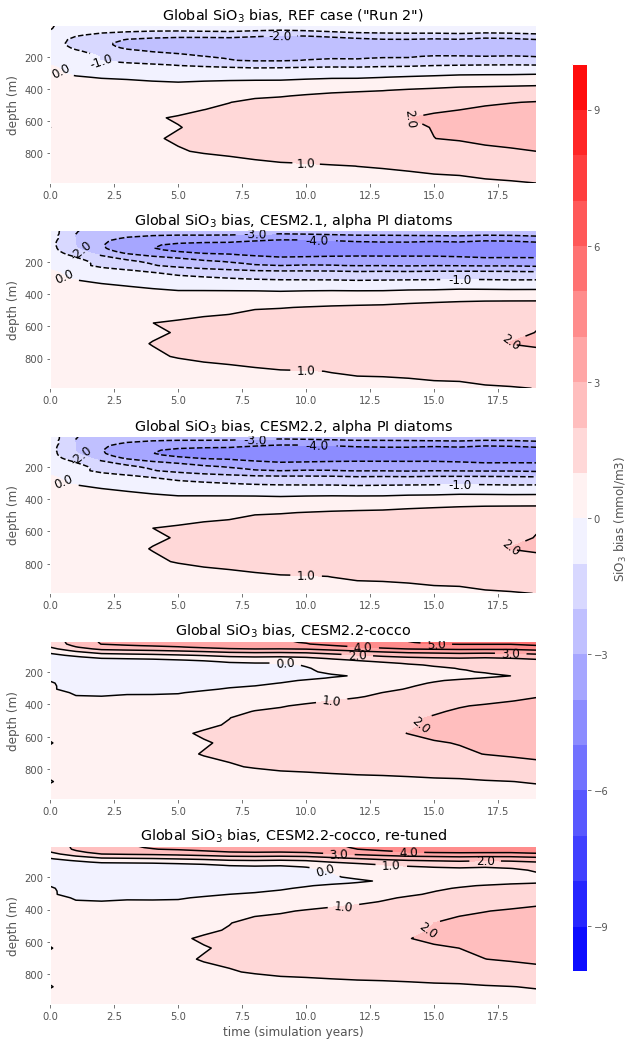

In [63]:
fig = plt.figure(figsize=(10,18))

#plt.title('Southern SiO$_3$ REF case: Run 2', fontsize=14)
levels = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]

ax = fig.add_subplot(5,1,1)
pc=ax.contourf(years, z_top, diff_glb_ref_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_glb_ref_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('Global SiO$_3$ bias, REF case ("Run 2")')

fig.subplots_adjust(right=0.8,hspace=0.3)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='SiO$_3$ bias (mmol/m3)')

#----------------------------------
ax = fig.add_subplot(5,1,2)
pc=ax.contourf(years, z_top, diff_glb_2_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_glb_2_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('Global SiO$_3$ bias, CESM2.1, alpha PI diatoms')



#----------------------------------
ax = fig.add_subplot(5,1,3)
pc=ax.contourf(years, z_top, diff_glb_3_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_glb_3_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('Global SiO$_3$ bias, CESM2.2, alpha PI diatoms')


#----------------------------------
ax = fig.add_subplot(5,1,4)
pc=ax.contourf(years, z_top, diff_glb_4_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_glb_4_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('Global SiO$_3$ bias, CESM2.2-cocco')

#----------------------------------
ax = fig.add_subplot(5,1,5)
pc=ax.contourf(years, z_top, diff_glb_5_top['SiO3'], levels, cmap='bwr')
contour = plt.contour(years, z_top, diff_glb_5_top['SiO3'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()
ax.set_title('Global SiO$_3$ bias, CESM2.2-cocco, re-tuned');

Make means over the last 5 years of model run to see more spatial information

In [64]:
ds_ref_mean = ds_ref_annmean_ts.isel(time=slice(14,20)).mean(dim='time')
ds2_mean = ds2_annmean_ts.isel(time=slice(14,20)).mean(dim='time')
ds3_mean = ds3_annmean_ts.isel(time=slice(14,20)).mean(dim='time')
ds4_mean = ds4_annmean_ts.isel(time=slice(14,20)).mean(dim='time')
ds5_mean = ds5_annmean_ts.isel(time=slice(14,20)).mean(dim='time')

In [65]:
ds_ref_mean_diff = ds_ref_mean - ds_woa
ds2_mean_diff = ds2_mean - ds_woa
ds3_mean_diff = ds3_mean - ds_woa
ds4_mean_diff = ds4_mean - ds_woa
ds5_mean_diff = ds5_mean - ds_woa

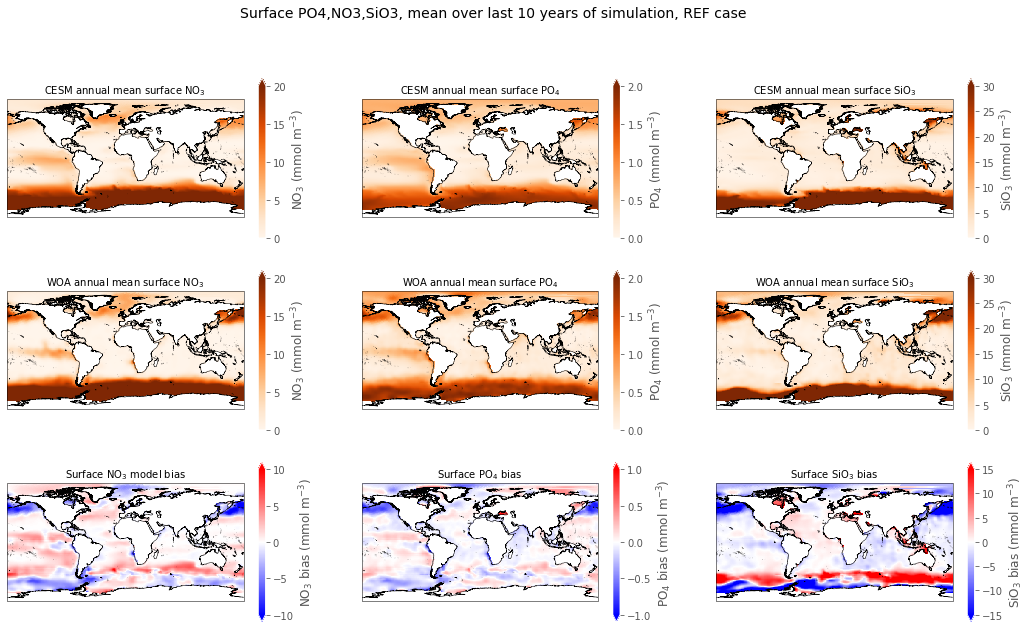

In [66]:
fig = plt.figure(figsize=(18,10))
plt.suptitle('Surface PO4,NO3,SiO3, mean over last 10 years of simulation, REF case', fontsize=14)

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_ref_mean.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds_ref_mean_diff.NO3.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_ref_mean.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds_ref_mean_diff.PO4.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_ref_mean.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds_ref_mean_diff.SiO3.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')

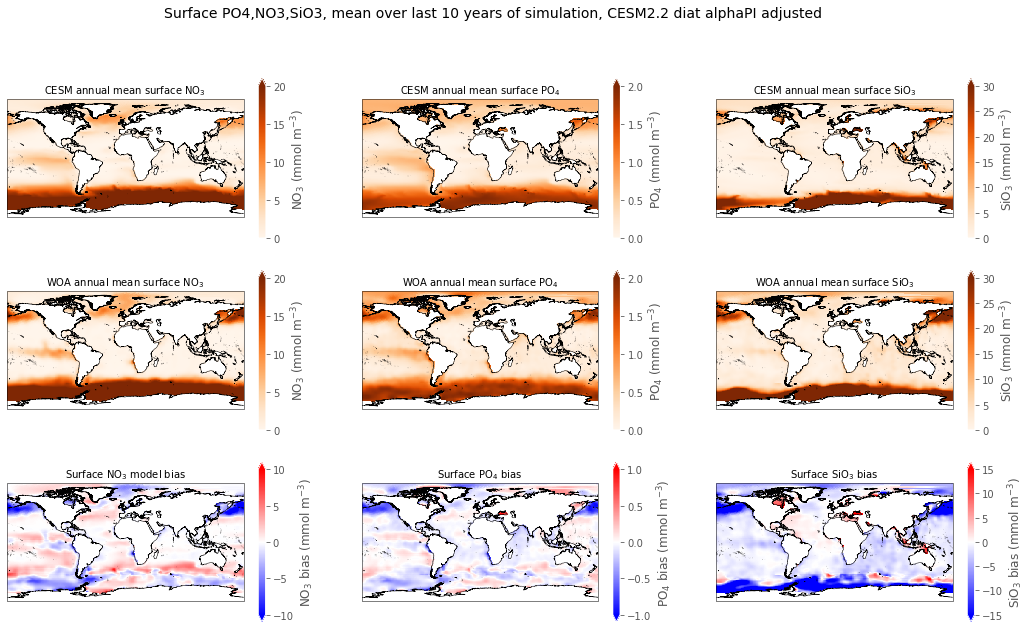

In [67]:
fig = plt.figure(figsize=(18,10))
plt.suptitle('Surface PO4,NO3,SiO3, mean over last 10 years of simulation, CESM2.2 diat alphaPI adjusted', fontsize=14)

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds3_mean.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds3_mean_diff.NO3.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds3_mean.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds3_mean_diff.PO4.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds3_mean.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds3_mean_diff.SiO3.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')

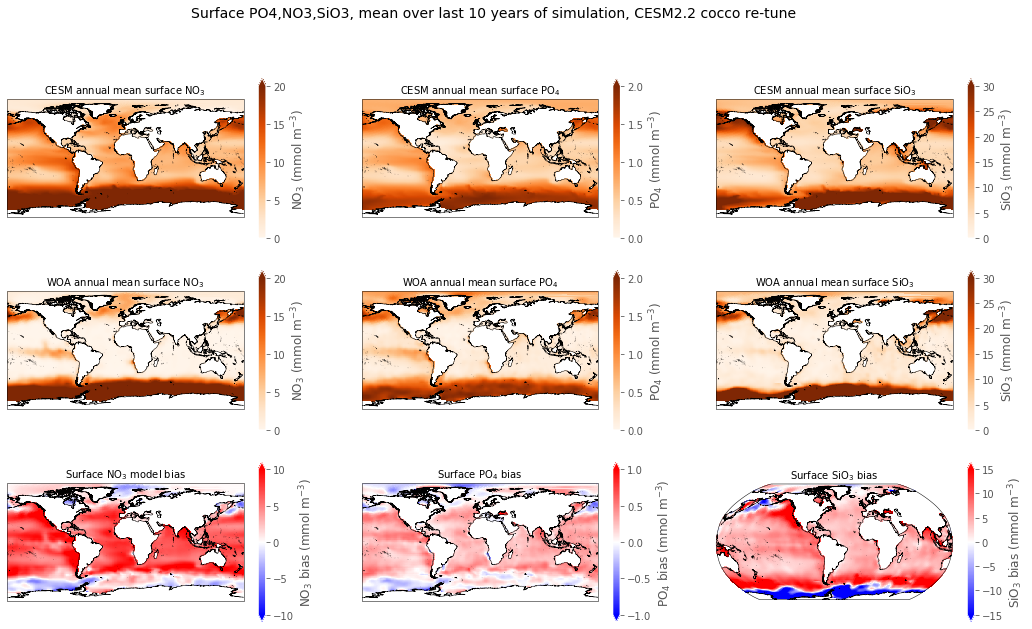

In [68]:
fig = plt.figure(figsize=(18,10))
plt.suptitle('Surface PO4,NO3,SiO3, mean over last 10 years of simulation, CESM2.2 cocco re-tune', fontsize=14)

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds5_mean.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds5_mean_diff.NO3.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds5_mean.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds5_mean_diff.PO4.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds5_mean.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds5_mean_diff.SiO3.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')

For cocco-re-tune:
Calculate timeseries of SiO3 in subtropical Pacific
Calculate timeseries of diatoms and coccolithophores in subtropical Pacific

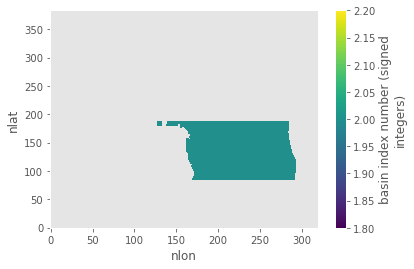

In [69]:
mask = ds_ref.REGION_MASK.where(ds_ref.REGION_MASK==2).where(lats<0)
mask.plot()

In [70]:
#do cesm2.2 cocco
ts_surf_SPac= xr.Dataset({v: ds_ref_annmean_ts[v] for v in ['time','z_t']})
ts_surf_SPac['SiO3'] = esmlab.weighted_mean(ds5_annmean_ts['SiO3'].where(mask==2), weights=area, dim=['nlat', 'nlon']).compute()
ts_surf_SPac['NO3'] = esmlab.weighted_mean(ds5_annmean_ts['NO3'].where(mask==2), weights=area, dim=['nlat', 'nlon']).compute()
ts_surf_SPac['PO4'] = esmlab.weighted_mean(ds5_annmean_ts['PO4'].where(mask==2), weights=area, dim=['nlat', 'nlon']).compute()

In [71]:
woa_SPac= xr.Dataset({v: ds_ref_annmean_ts[v] for v in ['z_t']})
woa_SPac['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'].where(mask==2), weights=area, dim=['nlat', 'nlon']).compute()

In [72]:
woa_timevals=np.array([ 0., 20.])
woa_SPacvals=np.array([ woa_SPac.SiO3.isel(z_t=0).values, woa_SPac.SiO3.isel(z_t=0).values])

[Text(0, 0.5, 'SiO$_3$ (mmol m$^{-3}$)'), Text(0.5, 0, 'year of simulation')]

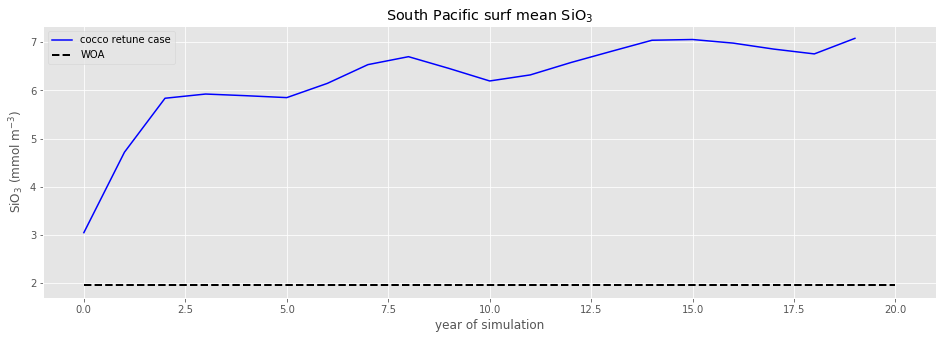

In [73]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('South Pacific surf mean SiO$_3$')
ax.plot(years,ts_surf_SPac['SiO3'].isel(z_t=0),color='blue',label='cocco retune case')
ax.plot(woa_timevals,woa_SPacvals,'--', linewidth=2,color='black',label='WOA')
ax.legend()
ax.set(ylabel='SiO$_3$ (mmol m$^{-3}$)',xlabel='year of simulation')